In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

c:\Users\Dell\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dell\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Dell\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('schedulenets.csv')

In [3]:
print(df.head())

             updatedAt        Date      Time     block_1
0  2018-11-06 17:31:06  2018-11-06  17:31:06  372.000000
1  2018-11-05 12:53:55  2018-11-05  12:53:55  372.000000
2  2018-11-12 17:16:58  2018-11-12  17:16:58  373.000000
3  2018-11-11 16:58:16  2018-11-11  16:58:16  373.000000
4  2018-11-13 16:52:33  2018-11-13  16:52:33  412.874368


In [4]:
# Convert 'time' column to datetime

# df['Date'] = df['Date']
# # df['Time'] = df['Time']

# df['Time'] = df['time'].dt.strftime('%H:%M')
df['time'] = pd.to_datetime(df['updatedAt'])

df['Date'] = df['time'].dt.date
df['Time'] = df['time'].dt.strftime('%H:%M')
df['Voltage']=df['block_1']

df = df[[ 'Date', 'Time','Voltage']]
df

,Date,Time,Voltage
0,2018-11-06,17:31,372.000000
1,2018-11-05,12:53,372.000000
2,2018-11-12,17:16,373.000000
3,2018-11-11,16:58,373.000000
4,2018-11-13,16:52,412.874368
...,...,...,...
10538,2021-06-11,09:30,200.000000
10539,2021-06-11,04:27,546.000000
10540,2021-06-11,06:07,466.000000
10541,2021-06-11,08:30,546.000000


In [5]:
df['Time_Intervals'] = df['Time'].apply(lambda x: f"{x[:2]}:{int(x[3:]) // 15 * 15:02d} to {x[:2]}:{(int(x[3:]) // 15 + 1) * 15:02d}")
df['Average_Voltage'] = df.groupby('Time_Intervals')['Voltage'].transform('mean')

df = df.groupby(['Date', 'Time_Intervals']).agg({'Average_Voltage': 'mean'}).reset_index()

df = df[[ 'Date', 'Time_Intervals','Average_Voltage']]
# df.to_csv('voltage_with_Intervals.csv', index=False) 
df

,Date,Time_Intervals,Average_Voltage
0,2018-11-05,12:45 to 12:60,417.272665
1,2018-11-05,17:30 to 17:45,407.169412
2,2018-11-06,17:30 to 17:45,407.169412
3,2018-11-10,16:45 to 16:60,386.672865
4,2018-11-11,16:45 to 16:60,386.672865
...,...,...,...
6540,2021-06-11,04:15 to 04:30,391.285290
6541,2021-06-11,06:00 to 06:15,401.741830
6542,2021-06-11,08:30 to 08:45,401.910695
6543,2021-06-11,09:00 to 09:15,397.025748


In [6]:
df.dtypes

Date                object
Time_Intervals      object
Average_Voltage    float64
dtype: object

In [7]:
# # Convert the 'Date' and 'Time_Intervals' columns to datetime
# df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time_Intervals'].str[:5])
# df.set_index('Datetime', inplace=True)
# df

In [8]:
# Convert Date to datetime if it's not already in the correct format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the time from Time_Intervals
df['Time'] = df['Time_Intervals'].str.extract(r'(\d{2}:\d{2})', expand=False)

# Concatenate Date and Time to create Datetime
df['Datetime'] = df['Date'].astype(str) + ' ' + df['Time']

# Convert Datetime to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set Datetime as the index
df.set_index('Datetime', inplace=True)

# Drop unnecessary columns if needed
df.drop(['Date', 'Time_Intervals', 'Time'], axis=1, inplace=True)

# Display the modified DataFrame
df


,Average_Voltage
Datetime,
2018-11-05 12:45:00,417.272665
2018-11-05 17:30:00,407.169412
2018-11-06 17:30:00,407.169412
2018-11-10 16:45:00,386.672865
2018-11-11 16:45:00,386.672865
...,...
2021-06-11 04:15:00,391.285290
2021-06-11 06:00:00,401.741830
2021-06-11 08:30:00,401.910695


In [9]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Voltage):
    result=adfuller(Voltage)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(df['Average_Voltage'])  

ADF Test Statistic : -10.40332169328537
p-value : 1.8846090008131363e-18
#Lags Used : 33
Number of Observations Used : 6511
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


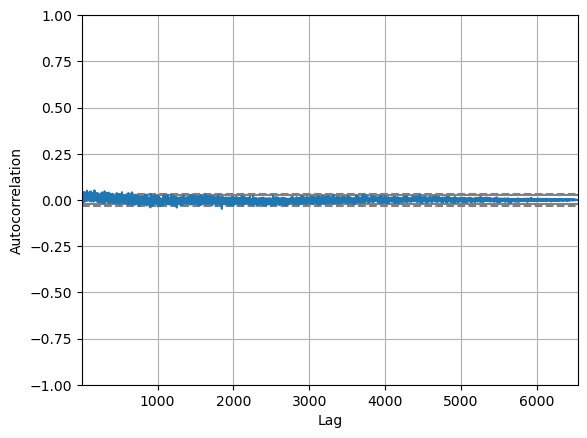

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Average_Voltage'])
plt.show()

In [11]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Average_Voltage'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65471.115, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63982.845, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65469.115, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63225.948, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=62923.592, Time=0.45 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=62710.251, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=62580.628, Time=0.96 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.63 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=62578.628, Time=0.40 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=62708.251, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=3.58 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Ti

In [12]:
model=ARIMA(df['Average_Voltage'],order=(5,1,0))
model_fit=model.fit()
model_fit.summary()

c:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Average_Voltage   No. Observations:                 6545
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -31283.314
Date:                Wed, 08 Nov 2023   AIC                          62578.628
Time:                        12:50:09   BIC                          62619.346
Sample:                             0   HQIC                         62592.706
                               - 6545                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7349      0.012    -59.637      0.000      -0.759      -0.711
ar.L2         -0.5886      0.015    -39.348      0.000      -0.618      -0.559
ar.L3         -0.4103      0.016    -26.151      0.000      -0.441      -0.380
ar.L4         -0.2800      0.015    -19.174      0.000      -0.309      -0.251
ar.L5         -0.1411      0.012    -11.565      0.000      -0.165      -0.117
sigma2       831.4775     15.373     54.087      0.000     801.347     861.608
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):                12.12
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.01
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#divide into train and validation set

train=df.iloc[:len(df)-365]
test=df.iloc[len(df)-365:]
# # Define the size of the training set (e.g., 80%)
# train_size = int(len(df) * 0.8)

# # Split the data into train and test sets
# train, test = df[0:train_size], df[train_size:]

print(train.shape,test.shape)

(6180, 1) (365, 1)


6180 6544


<AxesSubplot:xlabel='Datetime'>

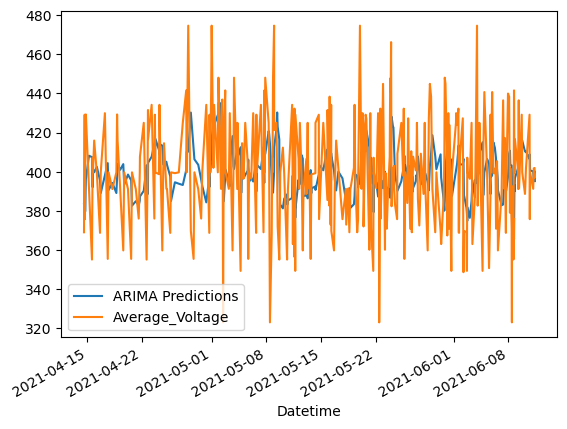

In [14]:
start=len(train)
end=len(train)+len(test)-1
print(start,end)
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Average_Voltage'].plot(legend=True)

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Average_Voltage'].mean()
rmse=sqrt(mean_squared_error(pred,test['Average_Voltage']))
print(rmse)

29.722355664987763


In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate the mean of the test data
mean_value = test['Average_Voltage'].mean()

# Calculate the RMSE
rmse = sqrt(mean_squared_error(pred, test['Average_Voltage']))

# Calculate the accuracy in percentage
accuracy = (1 - (rmse / mean_value)) * 100

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 92.56%
